In [1]:
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path


In [2]:
#---------------------------------------------------
# for plotting purposes we use this iPython magic
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (19, 19)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 1. Read training data

In [3]:
# read phu regions shapefile
phu_regions = gpd.read_file("data/0_shp/AOI__Province__865_PHUs__INDONESIA.gpkg")

In [4]:
df = pd.read_csv("data/9_clean_training_data/clean_training_data.csv")

# Convert to GeoDataFrame
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
# Set CRS to WGS84
df.crs = "EPSG:4326"

# add phu region to each point
df = gpd.sjoin(df, phu_regions, how="left", predicate="within")
df.head()

,source,id,date,gwl_cm,lat,lon,LIA,VH,VV,VVVH_ratio,...,region_id,percentile,geometry,index_right,island,province,phu_name,aoi_phu,tile_id,phu_id
0,pkeg,02_AHL_SBG-B076,2021-06-01,-41.0,3.93776,117.00775,32.785855,-11.481278,-5.556430,0.207099,...,10,0.005855,POINT (117.00775 3.93776),189.0,Kalimantan,North Kalimantan,KHG Sungai Sebuku - Sungai Sembakung,KAL_User_15,15.0,189.0
1,pkeg,02_AHL_SBG-B076,2021-08-24,-38.0,3.93776,117.00775,32.785295,-12.812067,-5.960235,0.201164,...,10,0.005855,POINT (117.00775 3.93776),189.0,Kalimantan,North Kalimantan,KHG Sungai Sebuku - Sungai Sembakung,KAL_User_15,15.0,189.0
2,pkeg,02_AHL_SBG-B076,2022-04-09,-22.0,3.93776,117.00775,32.795191,-18.437775,-10.636812,0.072032,...,10,0.005855,POINT (117.00775 3.93776),189.0,Kalimantan,North Kalimantan,KHG Sungai Sebuku - Sungai Sembakung,KAL_User_15,15.0,189.0
3,pkeg,02_AHL_SBG-B076,2023-02-15,-31.0,3.93776,117.00775,32.793740,-13.051827,-9.007584,0.076149,...,10,0.005855,POINT (117.00775 3.93776),189.0,Kalimantan,North Kalimantan,KHG Sungai Sebuku - Sungai Sembakung,KAL_User_15,15.0,189.0
4,pkeg,02_AHL_SBG-B101,2022-04-09,-34.0,3.93186,117.01012,39.270480,-16.941989,-10.601523,0.066845,...,10,0.016393,POINT (117.01012 3.93186),189.0,Kalimantan,North Kalimantan,KHG Sungai Sebuku - Sungai Sembakung,KAL_User_15,15.0,189.0


In [5]:
# Get the number of cases per PHU
phu_cases = df.groupby("phu_id").size().reset_index(name="observations")

In [6]:
phu_regions.head()

,island,province,phu_name,aoi_phu,tile_id,phu_id,geometry
0,Kalimantan,West Kalimantan,KHG Sungai Akar,KAL_User_11,11.0,0,"POLYGON ((110.97207 0.22002, 110.97214 0.21999..."
1,Kalimantan,West Kalimantan,KHG Sungai Ambawang - Sungai Kubu,KAL_User_11,11.0,1,"POLYGON ((109.10649 -0.34808, 109.10657 -0.348..."
2,Kalimantan,West Kalimantan,KHG Sungai Ambawang - Sungai Landak,KAL_User_11,11.0,2,"POLYGON ((109.95178 0.04852, 109.94685 0.04852..."
3,Kalimantan,West Kalimantan,KHG Sungai Batang Kalis - Sungai Maday,KAL_User_11,11.0,3,"POLYGON ((113.02373 0.67076, 113.02471 0.66952..."
4,Kalimantan,West Kalimantan,KHG Sungai Belimbing - Sungai Menunuh,KAL_User_11,11.0,4,"POLYGON ((111.66382 -0.32873, 111.66458 -0.331..."


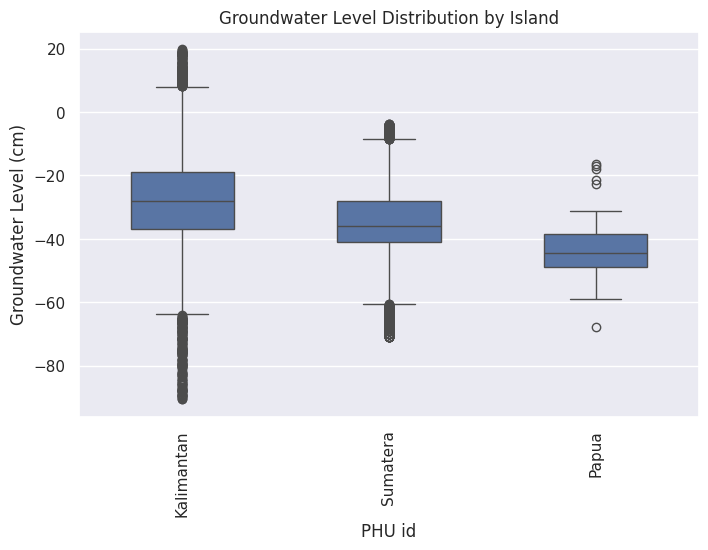

In [7]:
# get a boxplot of response var per region but use a small graph size

# set the seaborn style and size
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,5)})
sns.boxplot(x="island", y="gwl_cm", data=df, width=0.5)

# Rename x-axis with phu id
plt.xticks(rotation=90)
plt.xlabel("PHU id")
plt.ylabel("Groundwater Level (cm)")
plt.title("Groundwater Level Distribution by Island")
plt.show()

Text(0.5, 1.0, 'Groundwater Level Distribution by Province')

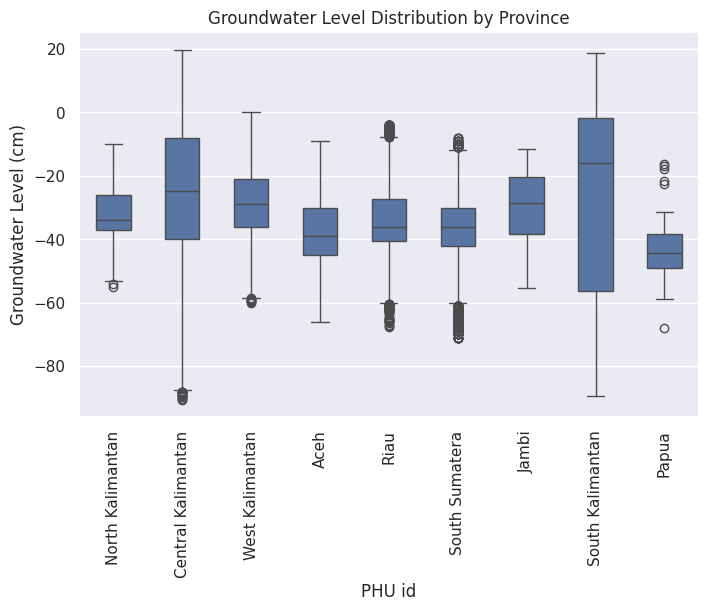

In [8]:
# get a boxplot of response var per region but use a small graph size

# set the seaborn style and size
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(8,5)})
sns.boxplot(x="province", y="gwl_cm", data=df, width=0.5)

# Rename x-axis with phu id
plt.xticks(rotation=90)
plt.xlabel("PHU id")
plt.ylabel("Groundwater Level (cm)")
plt.title("Groundwater Level Distribution by Province")

## Create a boxplot showing the number of dates per each point

In [9]:
# group by id and get the number of dates for each id
df_grouped = df.groupby("phu_name").count().reset_index()
df_grouped = df_grouped[["phu_name", "date"]]
df_grouped.columns = ["name", "date_count"]
df_grouped.sort_values(by="date_count", ascending=False)

,name,date_count
39,KHG Sungai Sugihan - Sungai Lumpur,7565
37,KHG Sungai Siak - Sungai Kampar,7042
3,KHG Pulau Padang,2589
33,KHG Sungai Rokan - Sungai Siak Kecil,2386
40,KHG Sungai Terentang - Sungai Kapuas,1543
27,KHG Sungai Merang - Sungai Ngirawan,1290
22,KHG Sungai Lalan - Sungai Merang,1044
38,KHG Sungai Siak Kecil - Sungai Siak,869
18,KHG Sungai Kapuas - Sungai Mendawak,848
13,KHG Sungai Kahayan - Sungai Sebangau,787


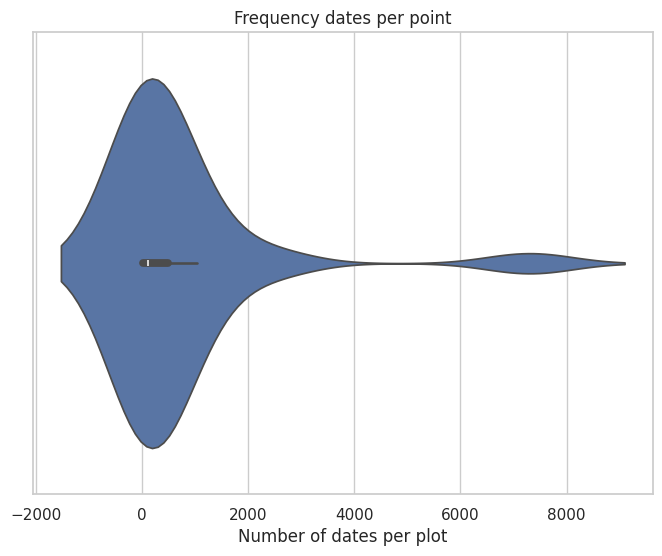

In [10]:
# Define the dimensions of the plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Create a violin plot for the variable
sns.violinplot(x=df_grouped["date_count"])

# Set the title and x-axis label
plt.title(f"Frequency dates per point")
plt.xlabel("Number of dates per plot")

plt.show()

In [11]:
# Define the percentiles you want to calculate as a list
percentiles = [0,5,10,25,50,75,90,100]  # You can adjust this list as needed

# Calculate the percentiles using numpy.percentile
percentile_values = np.percentile(df_grouped["date_count"], percentiles)

# Display the percentiles as a dictionary
percentile_list = list(zip(percentiles, percentile_values))
print("Percentiles:")
for p, value in percentile_list:
    print(f"{p}th percentile: {value}")
    
percentile_list

Percentiles:
0th percentile: 2.0
5th percentile: 5.15
10th percentile: 11.100000000000001
25th percentile: 15.75
50th percentile: 108.0
75th percentile: 501.0
90th percentile: 1517.6999999999996
100th percentile: 7565.0


[(0, 2.0),
 (5, 5.15),
 (10, 11.100000000000001),
 (25, 15.75),
 (50, 108.0),
 (75, 501.0),
 (90, 1517.6999999999996),
 (100, 7565.0)]

In [12]:
# drop all stations with less tan 9 observations
min_obs = 9
df.groupby('id').agg({'date': 'count'}).sort_values(by='date', ascending=False).reset_index()
df = df.groupby('id').filter(lambda group: len(group) >= min_obs)

In [13]:
from gee_scripts.parameters import explain_vars, response_var
print("dependent var", response_var)
print("explanatory lenght", len(explain_vars))

dependent var ['gwl_cm']
explanatory lenght 28


# 2. Define a model

In [14]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

## All but one test over stations

In [16]:
variable = 'gwl_cm'
temporal_expl = [
    'VV', 'VH', 'VVVH_ratio', 
    'precipitation', 'prec_3', 'prec_7', 'prec_30', 
    'sm_1',  'sm_3', 'sm_7', 'sm_30'
]
row = {}

high_corr_ids = pd.read_csv("data/high_corr_0.3_temporal_variables.csv")
high_corr_ids.columns = ["id"]
training_df = df[
    (df.island == "Kalimantan") & 
    (df.id.isin(high_corr_ids.id.unique()))
]

print(f"total points: {len(training_df)}")
print(f"total stations: {len(training_df.id.unique())}")

# All but one PHU for training
for i, station_id in enumerate(training_df.id.unique()):
    explans = []
    
    # define training subset
    train_df = training_df[training_df.id != station_id]
    
    # define test subset
    test_df = training_df[training_df.id == station_id]

    X_train, X_test = train_df[explain_vars], test_df[explain_vars]
    y_train, y_test = train_df[variable], test_df[variable]
    
    regr = RandomForestRegressor(
        n_estimators=250, 
        min_samples_leaf=1, 
        random_state=42, 
        oob_score=True, 
        criterion="friedman_mse", 
        n_jobs=-1
    )
    
    regr.fit(X_train, y_train)
    y_pred_test = regr.predict(X_test)
    
    r, p = pearsonr(y_test, y_pred_test)
    explans.append(r)
        
    explans.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))

    
    # add correlation of explanatories
    for expl in temporal_expl:
        explans.append(test_df[variable].corr(test_df[expl]))
    
    row[station_id] = explans
    
stats_df = pd.DataFrame.from_dict(row, orient='index')

total points: 1630
total stations: 68


In [34]:
# count the number of values per station
training_df.groupby('id').agg({'date': 'count'}).sort_values(by='date', ascending=False).reset_index()

,id,date
0,BRG_621103_05,97
1,BRG_621107_07,94
2,BRG_621107_06,89
3,BRG_621107_03,86
4,BRG_621107_08,84
...,...,...
61,10_MTI_MTI_H189_P4,9
62,10_MTI_MTI_J021_P2,9
63,10_MTI_MTI_J021_P3,9
64,10_MTI_MTI_J021_P4,9


<Axes: >

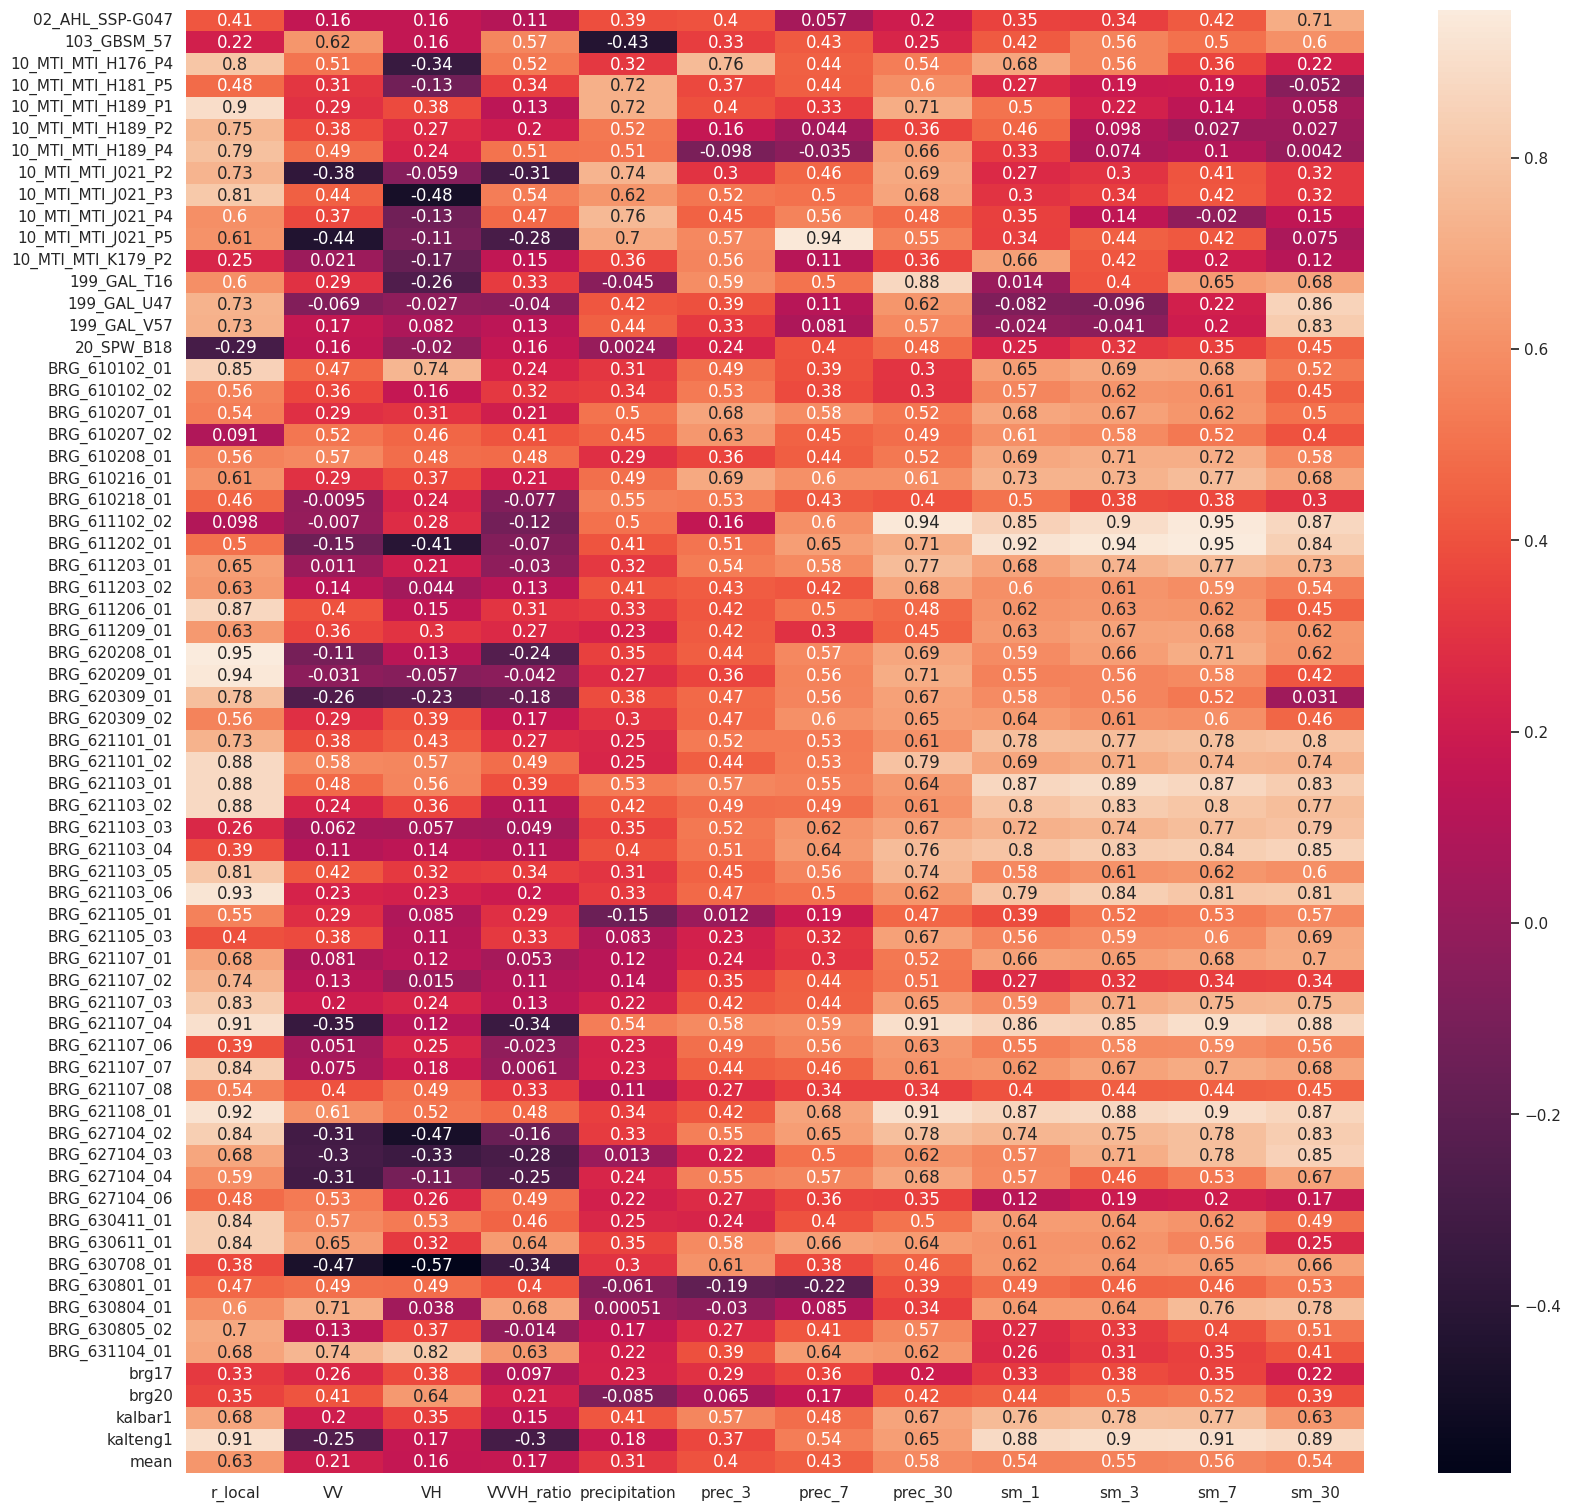

In [35]:
stats_df.columns = ["r_local", "rmse_local"] + temporal_expl

stats_df.loc['mean'] = stats_df.mean()
stats_df
sns.heatmap(stats_df[["r_local"] + temporal_expl], annot=True)

<Axes: >

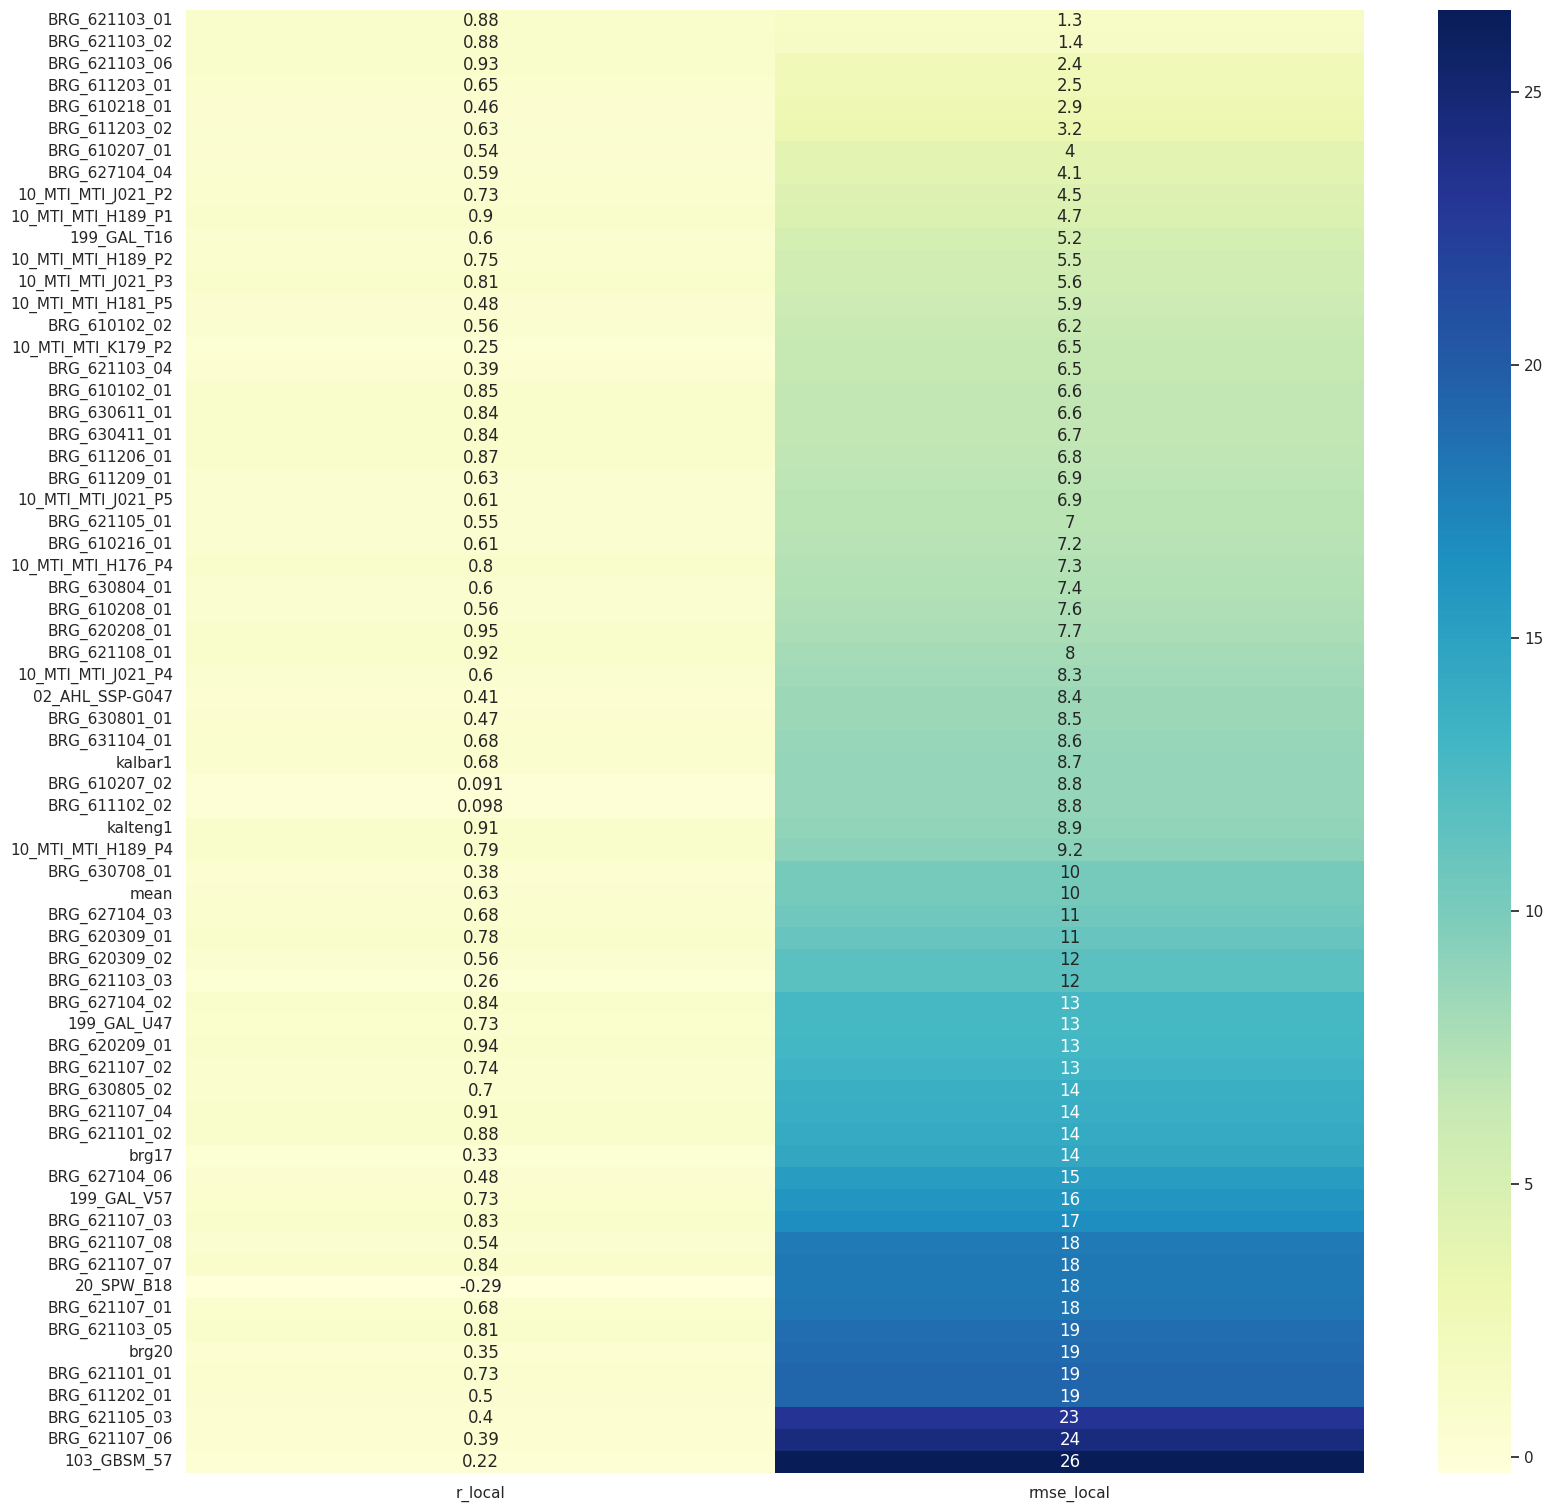

In [36]:
# invert colors for better visualization 
sns.heatmap(stats_df[["r_local", "rmse_local"]].sort_values(by="rmse_local"), annot=True, cmap="YlGnBu")

In [37]:
best_stations = stats_df[stats_df.rmse_local < 10].index
best_stations
len(best_stations)

39

## Model with best stations over all stations 

In [38]:
# split gdf into good statoins for train
gdf_high = training_df[training_df.id.isin(best_stations)].copy()
# and bad stations for test
gdf_low = training_df[~training_df.id.isin(best_stations)].copy()

variable = 'gwl_cm'

# create and train classifier
regr = RandomForestRegressor(n_estimators=250, min_samples_leaf=1, random_state=42, oob_score=True, criterion='friedman_mse', n_jobs=-1)

regr.fit(gdf_high[explain_vars], gdf_high[variable])


row = {}
#rmse_list = []
for station in gdf_low.id.unique():
    explans = []
    # apply model to specific station
    gdf_test = gdf_low[gdf_low.id == station]
    y_pred_test = regr.predict(gdf_test[explain_vars])

    # get pearsons r
    r, p = pearsonr(gdf_test[variable].values, y_pred_test)
    explans.append(r)

    explans.append(np.sqrt(mean_squared_error(gdf_test[variable].values, y_pred_test)))

    # add correlation of explanatories
    for expl in temporal_expl:
        explans.append(gdf_test[variable].corr(gdf_test[expl]))
     
    row[station] = explans
    #row[station] = [np.sqrt(mean_squared_error(gdf_test[variable].values, y_pred_test))]
    #print(row)
    
stats_df = pd.DataFrame.from_dict(row, orient='index')

In [39]:
## Save model to file with not pickle (pickle is not safe) 
import joblib
model_name = "Best_stations_Kalimantan"
joblib.dump(regr, f"data/10_models/{model_name}.joblib")

['data/10_models/Best_stations_Kalimantan.joblib']

<Axes: >

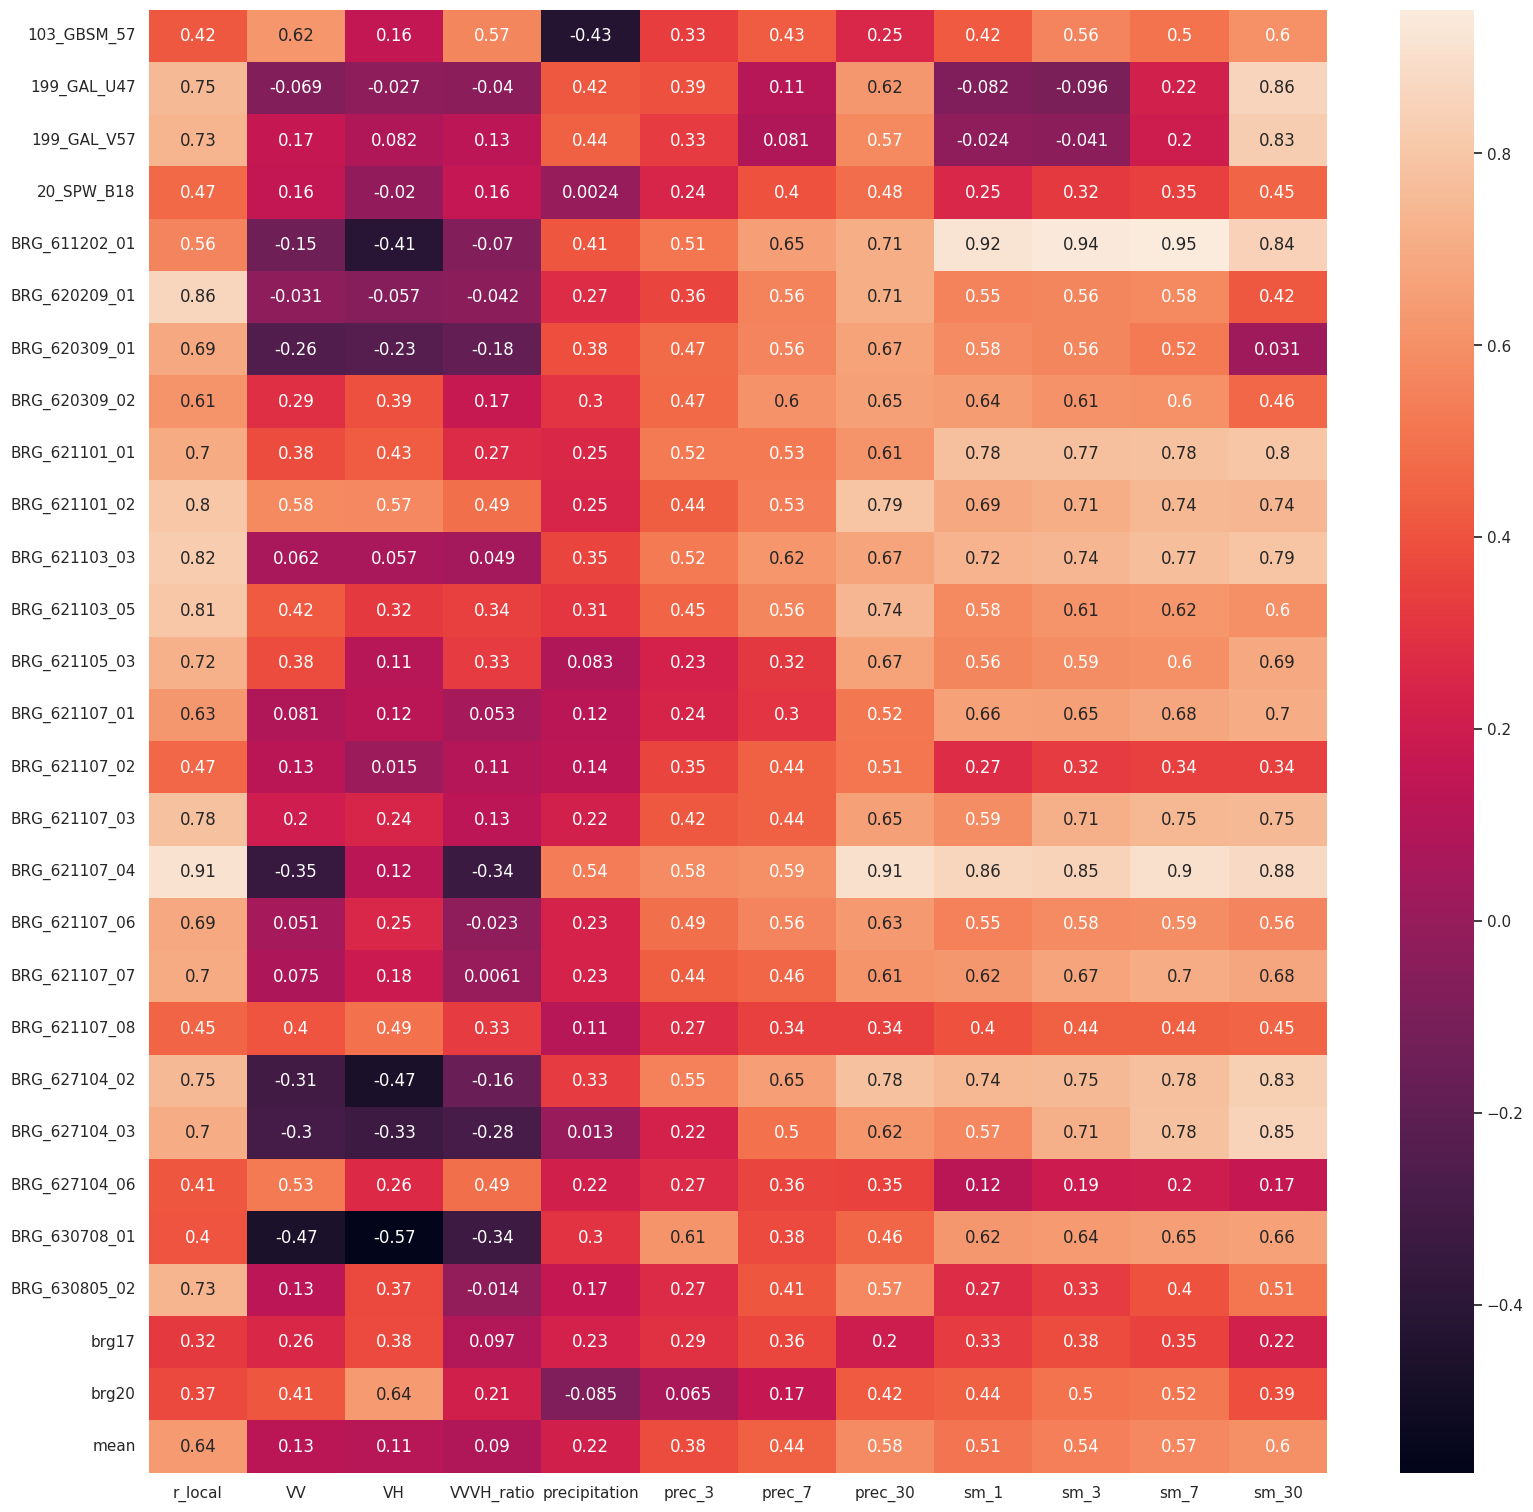

In [26]:
stats_df.columns = ["r_local", "rmse_local"] + temporal_expl
stats_df.loc['mean'] = stats_df.mean()
sns.heatmap(stats_df[["r_local"] + temporal_expl], annot=True)

<Axes: >

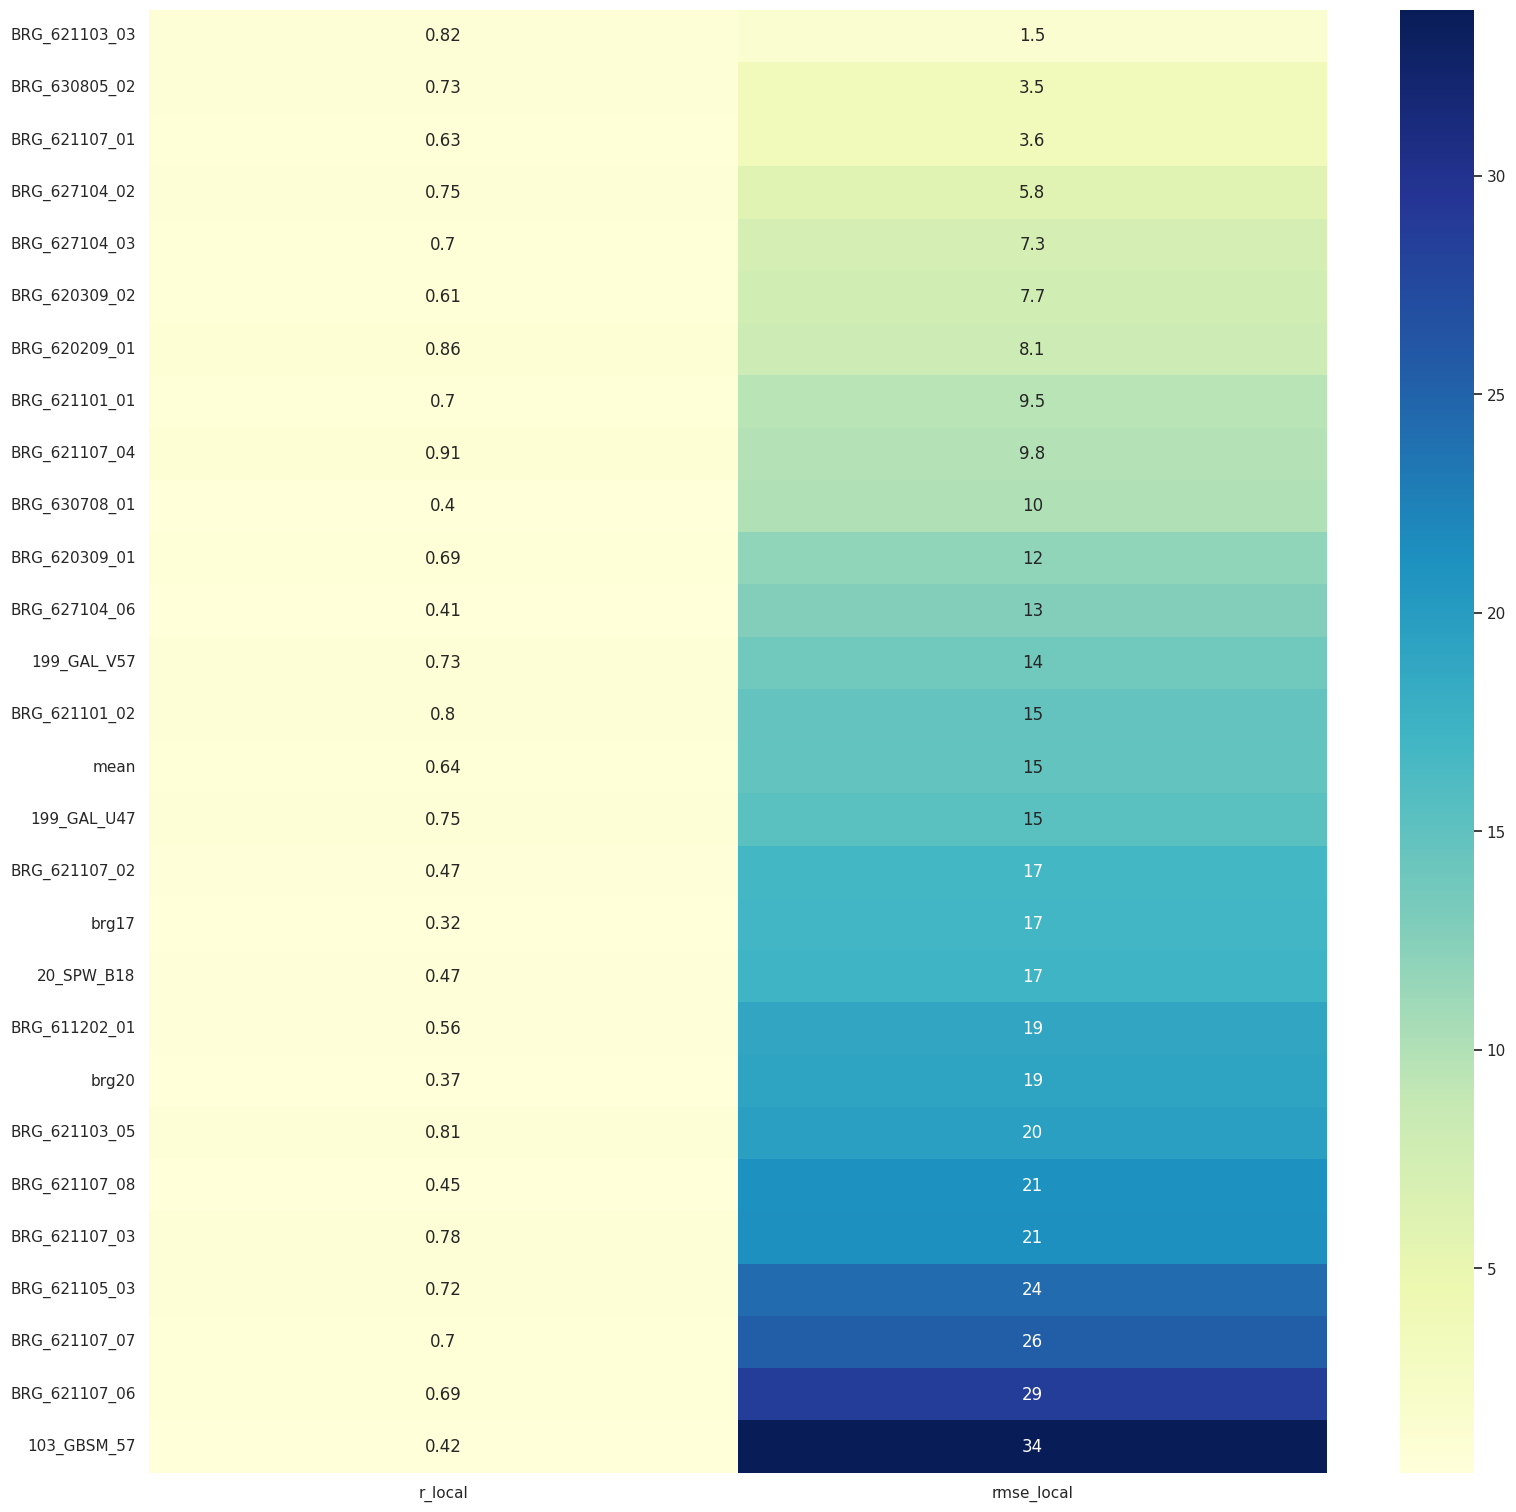

In [112]:
# invert colors for better visualization 
sns.heatmap(stats_df[["r_local", "rmse_local"]].sort_values(by="rmse_local"), annot=True, cmap="YlGnBu")

In [113]:
best_worse_stations = stats_df[stats_df.rmse_local < 10].index
best_worse_stations

Index(['BRG_620209_01', 'BRG_620309_02', 'BRG_621101_01', 'BRG_621103_03',
       'BRG_621107_01', 'BRG_621107_04', 'BRG_627104_02', 'BRG_627104_03',
       'BRG_630805_02'],
      dtype='object')

In [122]:
bootstrap_station = list(best_stations) + list(best_worse_stations)
len(bootstrap_station)

48

In [124]:
train_size=0.8
size = int(train_size*len(bootstrap_station))
print(size)

# get the good data
i = 0
r_list, r2_list, rmse_list = [], [], []
samples_train, samples_test = [], []

38


In [127]:
while i < 100: 

    train_list = np.random.choice(bootstrap_station, size=size, replace=False)
    #print(sorted(train_list), len(train_list))
    gdf_train = training_df[training_df.id.isin(train_list)].copy()
    gdf_test = training_df[~training_df.id.isin(train_list)].copy()
    #print(len(gdf_train), len(gdf_test))
    X_train, X_test = gdf_train[explain_vars], gdf_test[explain_vars]
    y_train, y_test = gdf_train[variable], gdf_test[variable]
    
    regr = RandomForestRegressor(n_estimators=250, min_samples_leaf=1, oob_score=True, criterion='friedman_mse', n_jobs=-1)
    regr.fit(X_train, y_train)
    y_pred_test = regr.predict(X_test)
    
    samples_train.append(len(gdf_train))
    samples_test.append(len(gdf_test))
    r, p = pearsonr(y_test, y_pred_test)
    r_list.append(r)
    
    r2_list.append(r2_score(y_test, y_pred_test))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
    
    i += 1

In [128]:
pd.DataFrame([
    [np.array(r_list).mean(), np.array(r_list).min(), np.array(r_list).max(), np.median(np.array(r_list))],
    [np.array(r2_list).mean(), np.array(r2_list).min(), np.array(r2_list).max(), np.median(np.array(r2_list))],
    [np.array(rmse_list).mean(), np.array(rmse_list).min(), np.array(rmse_list).max(), np.median(np.array(rmse_list))],
    [np.array(samples_train).mean(), np.array(samples_train).min(), np.array(samples_train).max()],
    [np.array(samples_test).mean(), np.array(samples_test).min(), np.array(samples_test).max()],
],
    index=["r", "r2", "rmse", "samples_train", "samples_test"],
    columns=["mean", "min", "max", "median"]
)


,mean,min,max,median
r,0.276609,0.171173,0.369627,0.279178
r2,-0.184737,-0.312193,-0.032143,-0.186891
rmse,19.129881,17.517776,20.122887,19.119775
samples_train,925.690000,821.000000,1019.000000,NaN
samples_test,1183.310000,1090.000000,1288.000000,NaN


In [ ]:
# Save model to file with not pickle (pickle is not safe) 
import joblib
model_name = "All_but_one_PHU_Kalimantan_high_corr_0_2_temporal_variables"
joblib.dump(regr, f"data/10_models/{model_name}.joblib")
plt.savefig(f"{model_name}.png")

In [64]:
# open unieqe points geopackage file
unique_points = gpd.read_file("data/0_shp/unique_stations_no_repeated.shp")

# export best estations to geopackage
unique_points[unique_points.id.isin(best_stations)].to_file("data/0_shp/best_kalimantan_corr02_rmse10.gpkg", driver='GPKG')

# # merge the stats_df with the unique_points
# unique_points = unique_points.merge(stats_df, left_on='id', right_index=True)

# # save the unique_points as a geopackage file
# unique_points.to_file("data/0_shp/kalimantan_r_local.gpkg", driver='GPKG')

In [ ]:
stats_df.sort_values(by="r_local", ascending=False).head(10)